In [1]:
from lib.datasets import ATPBind3D

from torchdrug import transforms

truncuate_transform = transforms.TruncateProtein(max_length=350, random=False)
protein_view_transform = transforms.ProteinView(view='residue')
transform = transforms.Compose([truncuate_transform, protein_view_transform])

dataset = ATPBind3D(transform=transform)

train_set, valid_set, test_set = dataset.split()
print("train samples: %d, valid samples: %d, test samples: %d" %
      (len(train_set), len(valid_set), len(test_set)))


Split num:  [337, 41, 41]
train samples: 337, valid samples: 41, test samples: 41


In [3]:
from torchdrug import core, layers, models
from torchdrug.layers import geometry
from torchdrug import transforms
import torch
from lib.tasks import NodePropertyPrediction
from lib.lr_scheduler import CosineAnnealingLR
from lib.disable_logger import DisableLogger


graph_construction_model = layers.GraphConstruction(node_layers=[geometry.AlphaCarbonNode()],
                                                    edge_layers=[geometry.SpatialEdge(radius=10.0, min_distance=5),
                                                                 geometry.KNNEdge(
                                                                     k=10, min_distance=5),
                                                                 geometry.SequentialEdge(max_distance=2)],
                                                    edge_feature="gearnet")
task = NodePropertyPrediction(
    models.GearNet(input_dim=21, hidden_dims=[512, 512, 512, 512, 512, 512], num_relation=7,
                   edge_input_dim=59, num_angle_bin=8,
                   batch_norm=True, concat_hidden=True, short_cut=True, readout="sum").cuda(1),
    graph_construction_model=graph_construction_model,
    normalization=False,
    num_mlp_layer=2,
    metric=("micro_auroc", "mcc")
)

optimizer = torch.optim.Adam(task.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=20, eta_min=1e-5)
with DisableLogger():
    solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                        gpus=[1], batch_size=1)


In [4]:
metrics = []

In [5]:
for i in range(20):
    solver.train(num_epoch=1)
    metrics.append(solver.evaluate("test"))
    scheduler.step()

15:03:14   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:03:14   Epoch 0 begin
15:03:16   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:03:16   binary cross entropy: 0.643827
15:03:42   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:03:42   binary cross entropy: 0.176637
15:04:08   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:04:08   binary cross entropy: 0.272863
15:04:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:04:34   binary cross entropy: 0.139747
15:04:43   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:04:43   Epoch 0 end
15:04:43   duration: 2.18 mins
15:04:43   speed: 2.57 batch / sec
15:04:43   ETA: 0.00 secs
15:04:43   max GPU memory: 1581.7 MiB
15:04:43   ------------------------------
15:04:43   average binary cross entropy: 0.182666
15:04:43   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:04:43   Evaluate on test
15:04:50   ------------------------------
15:04:50   mcc: 0.271905
15:04:50   micro_auroc: 0.775997
15:04:50   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:04:50   Epoch 1 begin
15:05:07   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:05:07   binary cross entropy

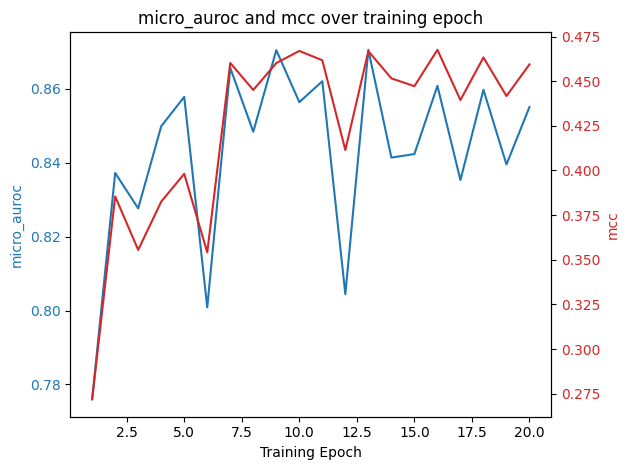

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


# metrics is your list of dictionaries
micro_auroc = [float(m['micro_auroc'].cpu().numpy())
               for m in metrics]  # convert tensors to floats
mcc = [m['mcc'] for m in metrics]

# Create x values, which are simply the index of each measurement
x_values = list(range(1, len(micro_auroc)+1))

# Create a new figure and add two subplots: one for each metric
fig, ax1 = plt.subplots()

# Plot the micro_auroc values in blue on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Training Epoch')
ax1.set_ylabel('micro_auroc', color=color)
ax1.plot(x_values, micro_auroc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the mcc values
ax2 = ax1.twinx()

# Plot the mcc values in red on the right y-axis
color = 'tab:red'
ax2.set_ylabel('mcc', color=color)
ax2.plot(x_values, mcc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('micro_auroc and mcc over training epoch')
fig.tight_layout()
plt.show()
